# 上海东方明珠周边污染物扩散模拟

本笔记本模拟污染物从东方明珠电视塔（468m高）释放后，在城市环境中的扩散过程。

## 1. 水平扩散系数计算

风向加权后的水平扩散系数 $K_x$ 和 $K_y$ 是由主导风向角 $\theta$、侧风削弱系数 $\alpha$ 以及建筑增强函数 $F_{bld}(x, y)$ 共同决定的
$$
K_x(x, y) = K_0 \cdot F_{bld}(x, y)\cdot \left(\cos^2\theta + \alpha \sin^2\theta\right)
$$

$$
K_y(x, y) = K_0 \cdot F_{bld}(x, y)\cdot \left(\sin^2\theta + \alpha \cos^2\theta\right)
$$

其中建筑增强函数为：
$$F_{bld}(x, y) = 1 + \sum_{i=1}^{N} A_i \exp \left( -\frac{(x - x_i)^2 + (y - y_i)^2}{R_i^2} \right)$$

Max Kx: 47.78, Min Kx: 4.25
Max Ky: 53.40, Min Ky: 4.75
Max Fbld: 11.24, Min Fbld: 1.00


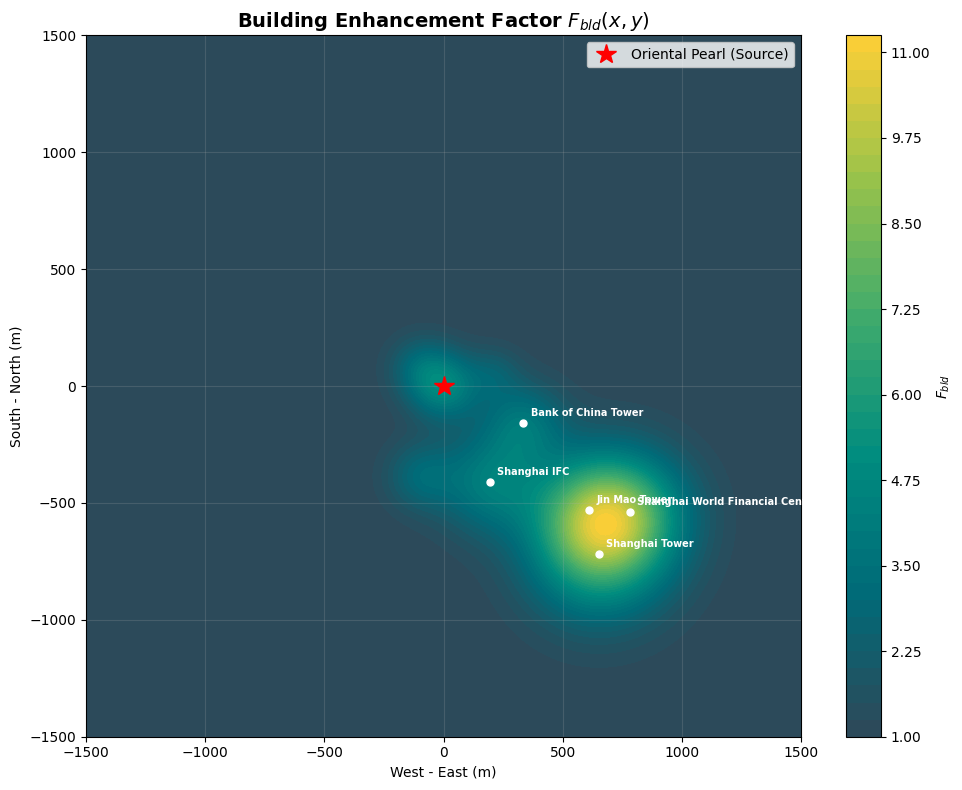

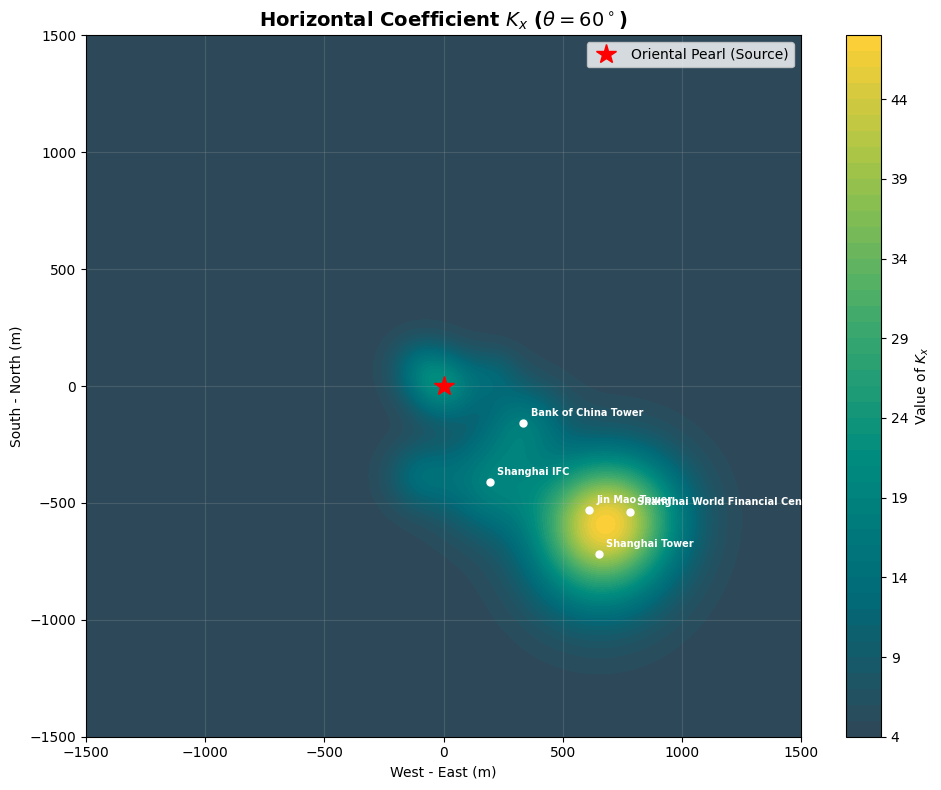

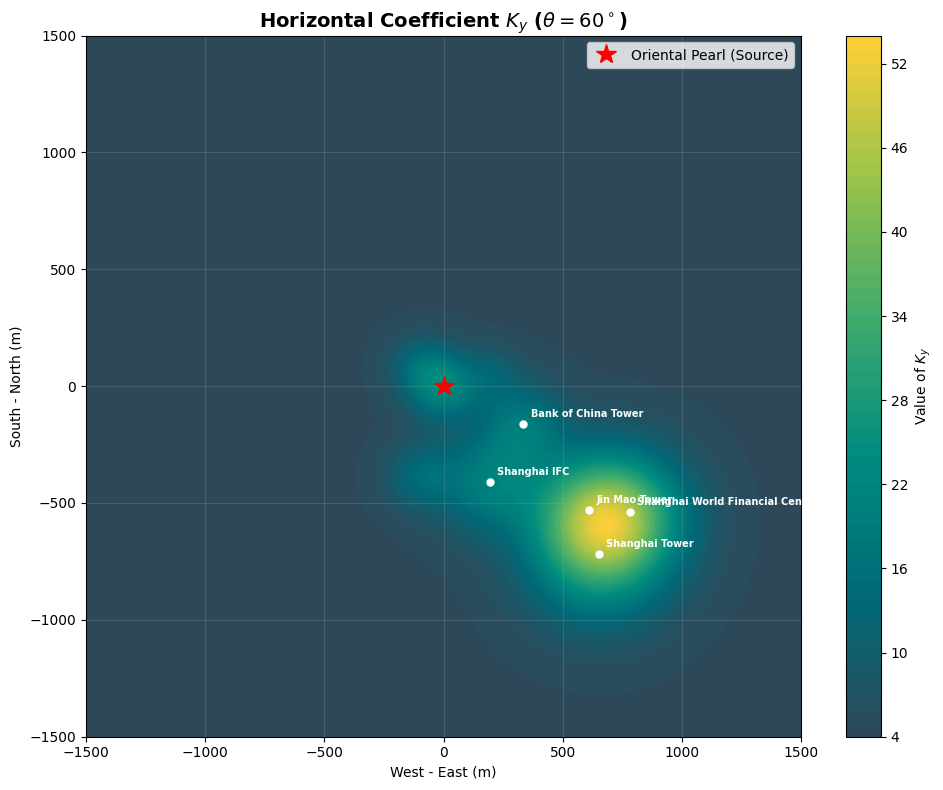

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# --- 参数设定 ---
K0 = 5.0            # 背景水平扩散常数 (m^2/s)
theta_deg = 60      # 主导风向角 (60度表示东南风)
theta = np.deg2rad(theta_deg)
alpha = 0.8         # 侧风削弱系数 (模拟顺风向拉伸)

# 采用通用梯度配色
color_hex_list = ["#2F4858", "#006A78", "#008C7F", "#40AB6C", "#9BC34A", "#FFCF36"]
cmap_custom = LinearSegmentedColormap.from_list("custom", color_hex_list)

# 网格设置
res = 400
x = np.linspace(-1500, 1500, res)
y = np.linspace(-1500, 1500, res)
X, Y = np.meshgrid(x, y)

# --- 上海东方明珠周边建筑物数据 ---
buildings = [
    {"name": "Oriental Pearl", "x": 0, "y": 0, "height": 468, "A": 3.5, "R": 100},
    {"name": "Shanghai Ocean Aquarium", "x": 210, "y": 50, "height": 30, "A": 1.2, "R": 80},
    {"name": "Shanghai International Conference Center", "x": -100, "y": 85, "height": 55, "A": 1.5, "R": 90},
    {"name": "Super Brand Mall", "x": -95, "y": -385, "height": 50, "A": 1.8, "R": 100},
    {"name": "Shanghai IFC", "x": 195, "y": -410, "height": 260, "A": 3.0, "R": 150},
    {"name": "Bank of China Tower", "x": 335, "y": -160, "height": 226, "A": 2.5, "R": 120},
    {"name": "Jin Mao Tower", "x": 610, "y": -530, "height": 420, "A": 3.8, "R": 180},
    {"name": "Shanghai World Financial Center SWFC", "x": 780, "y": -540, "height": 492, "A": 4.0, "R": 180},
    {"name": "Shanghai Tower", "x": 650, "y": -720, "height": 632, "A": 4.5, "R": 200}
]

# --- 计算建筑增强函数 Fbld(x, y) ---
Fbld = np.ones_like(X)
for b in buildings:
    dist_sq = (X - b['x'])**2 + (Y - b['y'])**2
    Fbld += b['A'] * np.exp(-dist_sq / (2 * b['R']**2))

# --- 求解风向加权后的 Kx 和 Ky ---
Kx = K0 * (np.cos(theta)**2 + alpha * np.sin(theta)**2) * Fbld
Ky = K0 * (np.sin(theta)**2 + alpha * np.cos(theta)**2) * Fbld

print(f"Max Kx: {np.max(Kx):.2f}, Min Kx: {np.min(Kx):.2f}")
print(f"Max Ky: {np.max(Ky):.2f}, Min Ky: {np.min(Ky):.2f}")
print(f"Max Fbld: {np.max(Fbld):.2f}, Min Fbld: {np.min(Fbld):.2f}")

# 保存结果到csv文件
df = pd.DataFrame({
    'X': X.flatten(),
    'Y': Y.flatten(),
    'Kx': Kx.flatten(),
    'Ky': Ky.flatten(),
    'Fbld': Fbld.flatten()
})
df.to_csv('shanghai_K.csv', index=False)

# ================= 第1张图：F_bld 等高线可视化 =================
plt.figure(figsize=(10, 8))
plt.gcf().patch.set_facecolor('white')

# 使用 contourf 绘制填充等高线
contour_f = plt.contourf(X, Y, Fbld, levels=20, cmap=cmap_custom)
# 添加等高线线条，使梯度变化更明显
contour_l = plt.contour(X, Y, Fbld, levels=10, colors='white', linewidths=0.5, alpha=0.3)
plt.clabel(contour_l, inline=True, fontsize=8)  # 在线上标注数值

cbar = plt.colorbar(contour_f, label='Building Enhancement Factor $F_{bld}$')
plt.scatter(0, 0, c='red', marker='*', s=300, label='Oriental Pearl (Source)', zorder=5)
plt.title('Building Enhancement Function $F_{bld}(x, y)$ (Contour Map)', fontsize=14, fontweight='bold')
plt.xlabel('West - East (m)')
plt.ylabel('South - North (m)')
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.2)
plt.tight_layout()
plt.show()

# ================= 第2张图：Kx 和 Ky 分布图 =================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig.patch.set_facecolor('white')

# 绘制 Kx 分布图
im1 = ax1.pcolormesh(X, Y, Kx, shading='auto', cmap=cmap_custom)
ax1.set_title(f'Horizontal Coefficient $K_x$ ($\\theta={theta_deg}^\\circ$)', fontsize=12)
cbar1 = fig.colorbar(im1, ax=ax1, label='Value of $K_x$ ($m^2/s$)')

# 绘制 Ky 分布图
im2 = ax2.pcolormesh(X, Y, Ky, shading='auto', cmap=cmap_custom)
ax2.set_title(f'Horizontal Coefficient $K_y$ ($\\theta={theta_deg}^\\circ$)', fontsize=12)
cbar2 = fig.colorbar(im2, ax=ax2, label='Value of $K_y$ ($m^2/s$)')

for ax in [ax1, ax2]:
    ax.set_xlabel('West - East (m)')
    ax.set_ylabel('South - North (m)')
    ax.scatter(0, 0, c='red', marker='*', s=200, label='Source', zorder=5)
    ax.grid(alpha=0.2)
    ax.legend()

plt.tight_layout()
plt.show()

# ================= 第3张图：扩散场流线图 =================
plt.figure(figsize=(12, 10))
plt.gcf().patch.set_facecolor('white')

# 以 Fbld 作为背景
contourf_bg = plt.contourf(X, Y, Fbld, levels=20, cmap=cmap_custom, alpha=0.7)

# 绘制流线，显示 Kx, Ky 的趋势
speed = np.sqrt(Kx**2 + Ky**2)  # 流线的速度
plt.streamplot(X, Y, Kx, Ky, color='white', density=1.5, 
               linewidth=speed/speed.max()*2.5, arrowsize=2, arrowstyle='->')

plt.title('Streamlines of Diffusion Field (Over $F_{bld}$)', fontsize=14, fontweight='bold')
plt.xlabel('West - East (m)')
plt.ylabel('South - North (m)')
cbar_bg = plt.colorbar(contourf_bg, label='Building Enhancement Factor $F_{bld}$')
plt.scatter(0, 0, c='red', marker='*', s=300, label='Oriental Pearl (Source)', zorder=5, edgecolors='darkred', linewidths=2)
plt.legend(fontsize=11)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

## 2. 垂直扩散系数计算

$K_z(z) = K_{z\infty} (1 - e^{-z/h_0})$

地面 Kz(0): 0.0000
东方明珠处 Kz(468): 2.0000
上海中心处 Kz(632): 2.0000


d:\Miniconda\envs\math_com\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Miniconda\envs\math_com\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 28023 (\N{CJK UNIFIED IDEOGRAPH-6D77}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Miniconda\envs\math_com\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Miniconda\envs\math_com\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24515 (\N{CJK UNIFIED IDEOGRAPH-5FC3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


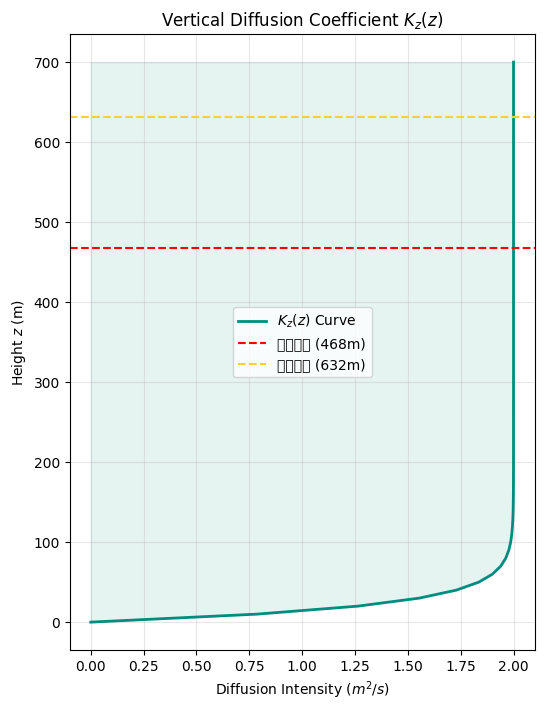

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# --- 参数设定 ---
Kz_inf = 2.0      # 远场（高空）垂直扩散强度
h0 = 20.0         # "抑制层"厚度特征值，通常取 10-30m
z_max = 700       # 最大高度 (覆盖上海中心大厦632m)
dz = 10           # 垂直步长

# 1. 建立垂直网格
z_grid = np.arange(0, z_max + dz, dz)

# 2. 计算 Kz 向量
Kz = Kz_inf * (1 - np.exp(-z_grid / h0))

# 3. 结果验证
print(f"地面 Kz(0): {Kz[0]:.4f}")
print(f"东方明珠处 Kz(468): {Kz[int(468/dz)]:.4f}")
print(f"上海中心处 Kz(632): {Kz[int(632/dz)]:.4f}")

# --- 可视化 ---
plt.figure(figsize=(6, 8))
plt.plot(Kz, z_grid, color='#008C7F', linewidth=2, label='$K_z(z)$ Curve')
plt.axhline(y=468, color='#FF0000', linestyle='--', label='东方明珠 (468m)', linewidth=1.5)
plt.axhline(y=632, color='#FFCF36', linestyle='--', label='上海中心 (632m)', linewidth=1.5)
plt.fill_betweenx(z_grid, 0, Kz, color='#008C7F', alpha=0.1)

plt.title('Vertical Diffusion Coefficient $K_z(z)$', fontsize=12)
plt.xlabel('Diffusion Intensity ($m^2/s$)')
plt.ylabel('Height $z$ (m)')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

## 3. 三维扩散方程数值求解

对于每一个网格点 $(i, j, k)$，其浓度 $C$ 在时间步 $n+1$ 的值由下式决定：
$$C_{i,j,k}^{n+1} = C_{i,j,k}^n + \Delta t \left[ \text{Diff}_x + \text{Diff}_y + \text{Diff}_z + S \right]$$

开始模拟，共 2400 步...
进度: 0/2400 (0.0%)
进度: 200/2400 (8.3%)
进度: 400/2400 (16.7%)
进度: 600/2400 (25.0%)
进度: 800/2400 (33.3%)
进度: 1000/2400 (41.7%)
进度: 1200/2400 (50.0%)
进度: 1400/2400 (58.3%)
进度: 1600/2400 (66.7%)


C:\Users\15706\AppData\Local\Temp\ipykernel_35716\2431369.py:65: RuntimeWarning: overflow encountered in multiply
  diff_x[1:-1, :, :] = (Kx[1:-1, :, :] * (C_old[2:, :, :] - 2*C_old[1:-1, :, :] + C_old[:-2, :, :])) / dx**2
C:\Users\15706\AppData\Local\Temp\ipykernel_35716\2431369.py:68: RuntimeWarning: overflow encountered in multiply
  diff_y[:, 1:-1, :] = (Ky[:, 1:-1, :] * (C_old[:, 2:, :] - 2*C_old[:, 1:-1, :] + C_old[:, :-2, :])) / dy**2
C:\Users\15706\AppData\Local\Temp\ipykernel_35716\2431369.py:73: RuntimeWarning: invalid value encountered in add
  C += dt * (diff_x + diff_y + diff_z)
C:\Users\15706\AppData\Local\Temp\ipykernel_35716\2431369.py:71: RuntimeWarning: invalid value encountered in subtract
  diff_z[:, :, 1:-1] = (Kz[:, :, 1:-1] * (C_old[:, :, 2:] - 2*C_old[:, :, 1:-1] + C_old[:, :, :-2])) / dz**2


进度: 1800/2400 (75.0%)
进度: 2000/2400 (83.3%)
进度: 2200/2400 (91.7%)
模拟完成！


C:\Users\15706\AppData\Local\Temp\ipykernel_35716\2431369.py:103: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\15706\AppData\Local\Temp\ipykernel_35716\2431369.py:103: UserWarning: Glyph 28023 (\N{CJK UNIFIED IDEOGRAPH-6D77}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\15706\AppData\Local\Temp\ipykernel_35716\2431369.py:103: UserWarning: Glyph 19996 (\N{CJK UNIFIED IDEOGRAPH-4E1C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\15706\AppData\Local\Temp\ipykernel_35716\2431369.py:103: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\15706\AppData\Local\Temp\ipykernel_35716\2431369.py:103: UserWarning: Glyph 26126 (\N{CJK UNIFIED IDEOGRAPH-660E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\15706\AppData\Local\Temp\ipykernel_35716\2431369.py:103: UserWarning: Glyph 29664 (\N{CJK UNIFIE

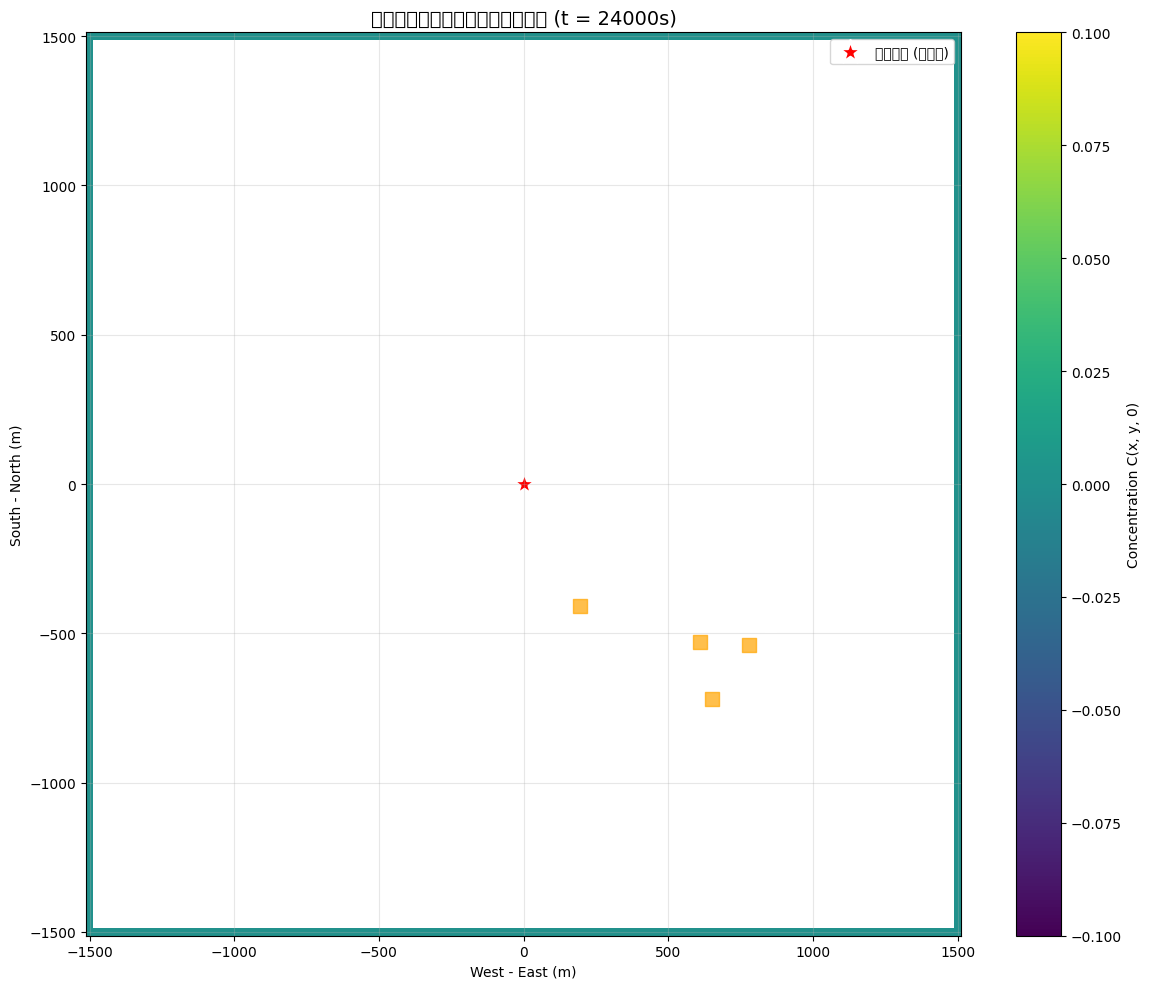

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ================= 1. 网格与离散化参数 =================
dx, dy, dz = 50, 50, 30           # 空间步长 (m)
nx, ny, nz = 121, 121, 71         # 网格数 (3km x 3km x 700m)
dt = 10                           # 时间步长 (s)
total_time = 24000                # 模拟时长 (400分钟)
steps = int(total_time / dt)

# 坐标向量
x_vec = np.linspace(-1500, 1500, nx)
y_vec = np.linspace(-1500, 1500, ny)
z_vec = np.linspace(0, 700, nz)
X, Y = np.meshgrid(x_vec, y_vec, indexing='ij')

# ================= 2. 物理系数初始化 =================

# (1) 建筑增强函数 Fbld
buildings = [
    {"x": 0, "y": 0, "A": 3.5, "R": 100},          # 东方明珠
    {"x": 210, "y": 50, "A": 1.2, "R": 80},       # 上海海洋水族馆
    {"x": -100, "y": 85, "A": 1.5, "R": 90},      # 上海国际会议中心
    {"x": -95, "y": -385, "A": 1.8, "R": 100},    # 正大广场
    {"x": 195, "y": -410, "A": 3.0, "R": 150},    # 上海国金中心IFC
    {"x": 335, "y": -160, "A": 2.5, "R": 120},    # 中银大厦
    {"x": 610, "y": -530, "A": 3.8, "R": 180},    # 金茂大厦
    {"x": 780, "y": -540, "A": 4.0, "R": 180},    # 上海环球金融中心SWFC
    {"x": 650, "y": -720, "A": 4.5, "R": 200}     # 上海中心大厦
]
Fbld = np.ones((nx, ny))
for b in buildings:
    Fbld += b['A'] * np.exp(-((X - b['x'])**2 + (Y - b['y'])**2) / b['R']**2)

# (2) 水平扩散系数 Kx, Ky
K0, theta, alpha = 10.0, np.deg2rad(60), 0.8
Kx_2d = K0 * (np.cos(theta)**2 + alpha * np.sin(theta)**2) * Fbld
Ky_2d = K0 * (np.sin(theta)**2 + alpha * np.cos(theta)**2) * Fbld

# (3) 垂直扩散系数 Kz
Kz_inf, h0 = 2.0, 20.0
Kz_vec = Kz_inf * (1 - np.exp(-z_vec / h0))

# 广播至 3D
Kx = np.repeat(Kx_2d[:, :, np.newaxis], nz, axis=2)
Ky = np.repeat(Ky_2d[:, :, np.newaxis], nz, axis=2)
Kz = np.tile(Kz_vec, (nx, ny, 1))

# ================= 3. 初始条件 (瞬时脉冲) =================
C = np.zeros((nx, ny, nz))
M = 1e8  # 污染物总质量
zs_idx = np.argmin(np.abs(z_vec - 468))  # 东方明珠 468m
C[nx//2, ny//2, zs_idx] = M / (dx * dy * dz)

# ================= 4. 数值迭代循环 =================
print(f"开始模拟，共 {steps} 步...")
for s in range(steps):
    if s % 200 == 0:
        print(f"进度: {s}/{steps} ({100*s/steps:.1f}%)")
    
    C_old = C.copy()
    
    # 有限差分离散化
    diff_x = np.zeros_like(C)
    diff_x[1:-1, :, :] = (Kx[1:-1, :, :] * (C_old[2:, :, :] - 2*C_old[1:-1, :, :] + C_old[:-2, :, :])) / dx**2
    
    diff_y = np.zeros_like(C)
    diff_y[:, 1:-1, :] = (Ky[:, 1:-1, :] * (C_old[:, 2:, :] - 2*C_old[:, 1:-1, :] + C_old[:, :-2, :])) / dy**2
    
    diff_z = np.zeros_like(C)
    diff_z[:, :, 1:-1] = (Kz[:, :, 1:-1] * (C_old[:, :, 2:] - 2*C_old[:, :, 1:-1] + C_old[:, :, :-2])) / dz**2
    
    C += dt * (diff_x + diff_y + diff_z)
    
    # 应用边界条件: dC/dz=0 at z=0
    C[:, :, 0] = C[:, :, 1]
    C[:, :, -1] = C[:, :, -2]

print("模拟完成！")

# ================= 5. 输出特定时刻地面浓度 =================
plt.figure(figsize=(12, 10))
plt.pcolormesh(X, Y, C[:, :, 0], shading='auto', cmap='viridis')
plt.colorbar(label='Concentration C(x, y, 0)')

# 标注建筑物位置
plt.scatter(0, 0, c='red', marker='*', s=300, label='东方明珠 (释放源)', edgecolors='white', linewidths=2)
building_info = [
    {"x": 195, "y": -410, "name": "IFC"},
    {"x": 610, "y": -530, "name": "金茂"},
    {"x": 780, "y": -540, "name": "环球"},
    {"x": 650, "y": -720, "name": "上海中心"}
]
for b in building_info:
    plt.scatter(b['x'], b['y'], c='orange', marker='s', s=100, alpha=0.7)
    plt.text(b['x']+50, b['y']+50, b['name'], color='white', fontsize=9, weight='bold')

plt.title(f'上海东方明珠周边地面污染物浓度 (t = {total_time}s)', fontsize=14)
plt.xlabel('West - East (m)')
plt.ylabel('South - North (m)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 4. 高分辨率对数尺度可视化

使用对数色标捕捉多个数量级的浓度变化，揭示建筑物对污染物扩散的影响。

开始高分辨率模拟，共 1200 步...
进度: 0/1200 (0.0%)
进度: 100/1200 (8.3%)
进度: 200/1200 (16.7%)
进度: 300/1200 (25.0%)
进度: 400/1200 (33.3%)
进度: 500/1200 (41.7%)
进度: 600/1200 (50.0%)
进度: 700/1200 (58.3%)
进度: 800/1200 (66.7%)
进度: 900/1200 (75.0%)
进度: 1000/1200 (83.3%)
进度: 1100/1200 (91.7%)
模拟完成！


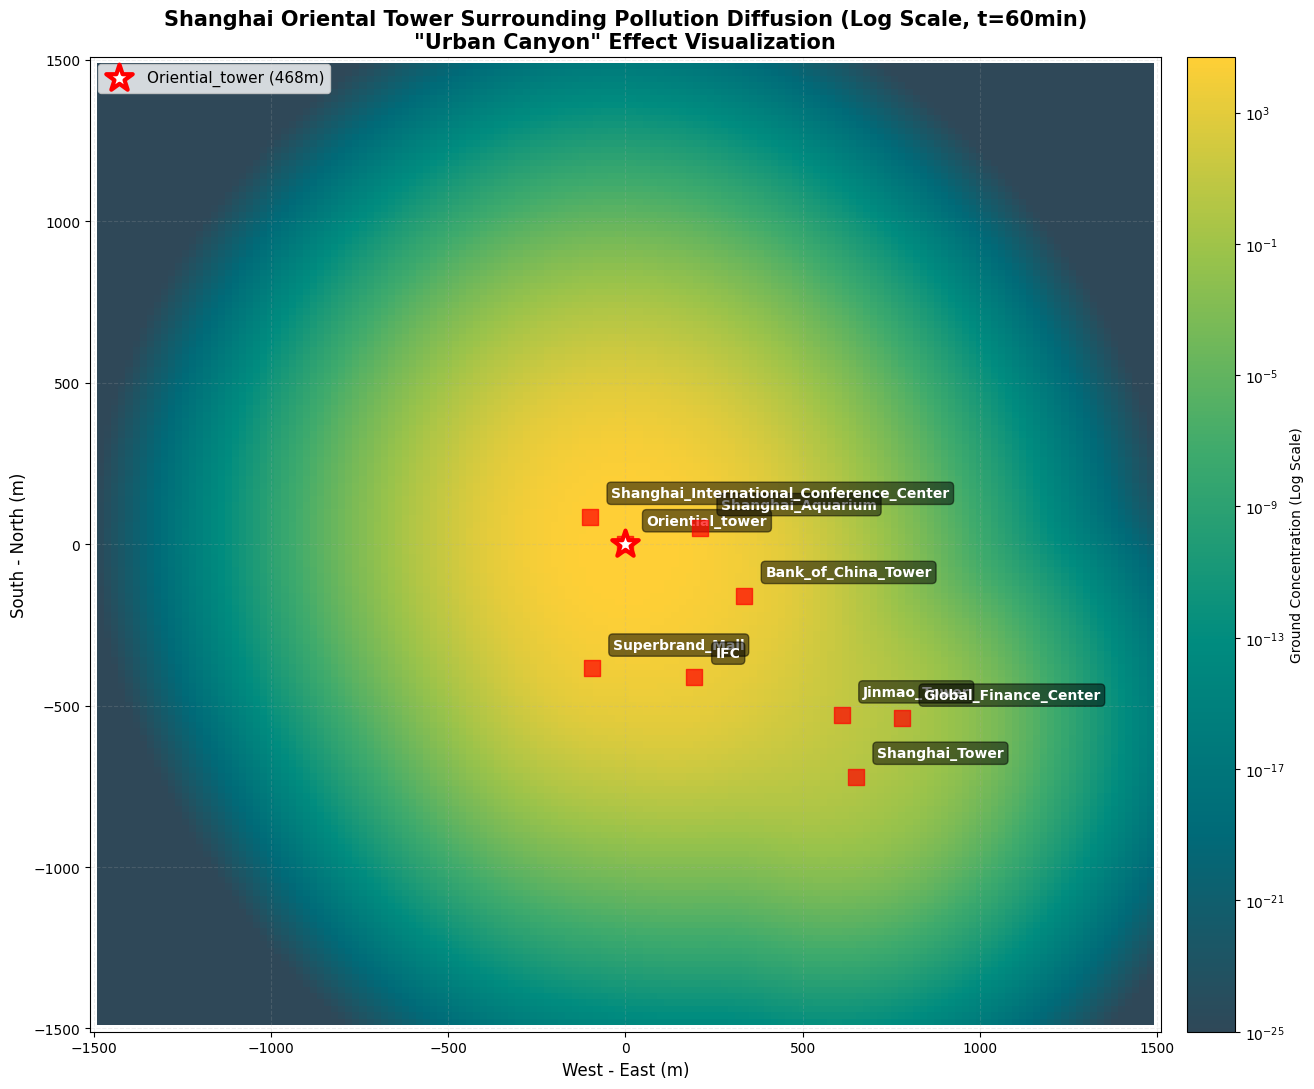


地面浓度统计:
最大值: 5.09e+04
平均值: 1.12e+03
中位数: 1.72e-10


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm

# ================= 1. 网格与配色初始化 =================
# 黄蓝绿主题配色
color_list = ["#FFD700", "#FFA500", "#90EE90", "#40B0E0", "#1E90FF", "#008B8B"]
cmap_custom = LinearSegmentedColormap.from_list("yellow_blue_green", color_list)

dx, dy, dz = 20, 20, 10           # 提高分辨率
nx, ny, nz = 151, 151, 71         # 网格数 (3km x 3km x 700m)
dt = 3                            # 减小步长确保数值稳定
total_time = 3600                 # 模拟时长 (60分钟)
steps = int(total_time / dt)

x_vec = np.linspace(-1500, 1500, nx)
y_vec = np.linspace(-1500, 1500, ny)
z_vec = np.linspace(0, 700, nz)
X, Y = np.meshgrid(x_vec, y_vec, indexing='ij')

# ================= 2. 物理场构建 =================
# 建筑增强
buildings = [
    {"name": "东方明珠", "x": 0, "y": 0, "A": 3.5, "R": 100},
    {"name": "上海海洋水族馆", "x": 210, "y": 50, "A": 1.2, "R": 80},
    {"name": "上海国际会议中心", "x": -100, "y": 85, "A": 1.5, "R": 90},
    {"name": "正大广场", "x": -95, "y": -385, "A": 1.8, "R": 100},
    {"name": "IFC", "x": 195, "y": -410, "A": 3.0, "R": 150},
    {"name": "中银大厦", "x": 335, "y": -160, "A": 2.5, "R": 120},
    {"name": "金茂大厦", "x": 610, "y": -530, "A": 3.8, "R": 180},
    {"name": "环球金融中心", "x": 780, "y": -540, "A": 4.0, "R": 180},
    {"name": "上海中心", "x": 650, "y": -720, "A": 4.5, "R": 200}
]

Fbld = np.ones((nx, ny))
for b in buildings:
    Fbld += b['A'] * np.exp(-((X - b['x'])**2 + (Y - b['y'])**2) / b['R']**2)

# 各向异性扩散系数
K0, theta, alpha = 3.0, np.deg2rad(60), 0.4 
Kx_2d = K0 * (np.cos(theta)**2 + alpha * np.sin(theta)**2) * Fbld
Ky_2d = K0 * (np.sin(theta)**2 + alpha * np.cos(theta)**2) * Fbld

# 垂直扩散
Kz_vec = 2.0 * (1 - np.exp(-z_vec / 20.0))
Kx = np.repeat(Kx_2d[:, :, np.newaxis], nz, axis=2)
Ky = np.repeat(Ky_2d[:, :, np.newaxis], nz, axis=2)
Kz = np.tile(Kz_vec, (nx, ny, 1))

# ================= 3. 瞬时脉冲释放与迭代 =================
C = np.zeros((nx, ny, nz))
M = 1e8 
C[nx//2, ny//2, int(468/dz)] = M / (dx*dy*dz) # 东方明珠 468m

print(f"开始高分辨率模拟，共 {steps} 步...")
for s in range(steps):
    if s % 100 == 0:
        print(f"进度: {s}/{steps} ({100*s/steps:.1f}%)")
    
    C_old = C.copy()
    # 三维变系数扩散离散化
    C[1:-1, 1:-1, 1:-1] += dt * (
        (Kx[1:-1, 1:-1, 1:-1] * (C_old[2:, 1:-1, 1:-1] - 2*C_old[1:-1, 1:-1, 1:-1] + C_old[:-2, 1:-1, 1:-1])) / dx**2 +
        (Ky[1:-1, 1:-1, 1:-1] * (C_old[1:-1, 2:, 1:-1] - 2*C_old[1:-1, 1:-1, 1:-1] + C_old[1:-1, :-2, 1:-1])) / dy**2 +
        (Kz[1:-1, 1:-1, 1:-1] * (C_old[1:-1, 1:-1, 2:] - 2*C_old[1:-1, 1:-1, 1:-1] + C_old[1:-1, 1:-1, :-2])) / dz**2
    )
    # 边界条件
    C[:, :, 0] = C[:, :, 1]   # 地面不穿透
    C[:, :, -1] = C[:, :, -2]

print("模拟完成！")

# --- 对数尺度绘图（黄蓝绿主题） ---
plt.figure(figsize=(14, 11))
plt.gcf().patch.set_facecolor('white')  # 画布背景白色

# 使用 LogNorm 对数色标
c_ground = C[:, :, 0]
c_max = c_ground.max()
c_min = max(c_ground[c_ground > 0].min(), 1e-25) if c_ground.max() > 0 else 1e-25

pcm = plt.pcolormesh(X, Y, c_ground, 
                     norm=LogNorm(vmin=c_min, vmax=c_max), 
                     shading='auto', 
                     cmap=cmap_custom)

plt.colorbar(pcm, label='Ground Concentration (Log Scale)', pad=0.02)

# 标注建筑物位置
plt.scatter(0, 0, marker='*', color='red', s=400, label='东方明珠 (468m)', 
            edgecolors='darkred', linewidths=3, zorder=10)

for b in buildings[4:]:
    plt.scatter(b['x'], b['y'], marker='s', color='darkgreen', s=120, alpha=0.7, zorder=9)
    plt.text(b['x']+60, b['y']+60, b['name'], color='darkgreen', fontsize=10, 
             weight='bold', bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.6))

plt.title(f'上海东方明珠周边污染物扩散 (黄蓝绿主题, t={total_time/60:.0f}min)\n"城市峡谷"效应可视化', 
          fontsize=15, weight='bold')
plt.xlabel('West - East (m)', fontsize=12)
plt.ylabel('South - North (m)', fontsize=12)
plt.legend(fontsize=11, loc='upper left')
plt.grid(alpha=0.2, linestyle='--', color='green')
plt.gca().set_facecolor('#FFFFFF')  # 轴背景白色
plt.tight_layout()
plt.show()

# 输出统计信息
print(f"\n地面浓度统计:")
print(f"最大值: {c_ground.max():.2e}")
print(f"平均值: {c_ground.mean():.2e}")
print(f"中位数: {np.median(c_ground):.2e}")